# MEATY Analysis

In [1]:
from MEATY_backend import *
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
import datetime as dt
%matplotlib inline
import queue
from pytesseract import image_to_string
from PIL import Image
from itertools import combinations as combos
import imagehash as ihash
get_date = lambda x: x.date()
get_dayofweek = lambda x: x.dayofweek

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

list_of_groups = ['harvard', 'yale',
                  'princeton', 'columbia', 'dartmouth', 'cornell', 'penn', 'brown']
school_colors = ['#A51C30', '#0f4d92', '#EE7F2D', '#9BDDFF', '#00693E','#B31B1B', '#41118D',
                 '#4E3629']
color_dic = dict(zip(list_of_groups, school_colors))

In [2]:
def load_postdata(remove_album_dupes=True):
    df = pd.read_csv('../all_memedata_dedupe.csv',
                     parse_dates=['post_time', 'post_date']).set_index('id')
    if remove_album_dupes:
        df = postwise_df(df)
    return df

In [3]:
def load_member_counts(list_of_groups=['cornell', 'harvard', 'yale', 'princeton',
                                       'columbia', 'dartmouth', 'penn', 'brown'],
                       date_min=dt.date(2016, 11, 15), date_max=dt.date(2017, 11, 15)):
    df = pd.read_csv('../all_member_data.csv', parse_dates=['date'])
    count_idx = pd.date_range(date_min, date_max)
    count_dic = {}
    for g in list_of_groups:
        gdf = df.groupby(['date', 'group']).group.count().groupby('group').cumsum()[:, g].reindex(count_idx,
                                                                                                      method='ffill')
        count_dic[g] = gdf
    count_df = pd.DataFrame(count_dic)
    return count_df

In [4]:
def extract_text(img_fn):
    img = Image.open(img_fn)
    text = " ".join(image_to_string(img, lang='eng').split('\n'))
    return (post_id, text)

In [5]:
def extract_all_text(n_threads, df):
    ids = df.id.values
    all_img_text = threads(n_threads, ids, extract_text)
    imtext_df = pd.DataFrame(all_img_text, columns=['id', 'img_text'])
    df_text = pd.merge(df, imtext_df)
    return df_text

In [6]:
def postwise_df(df):
#     df = load_memedata()
    post_df = df.drop_duplicates(['caption', 'post_time', 'num_reacts', 'poster_name','title'])
    post_df['post_time'] = pd.DatetimeIndex(post_df['post_time'])
    post_df.sort_values('post_time', inplace=True)
    post_df['cumulative_reacts'] = post_df.groupby('poster_name')['num_reacts'].transform(pd.Series.cumsum)
    return post_df

In [7]:
def reposted_imgs(df):
    df[df.img_hash.isin
       (df.img_hash.value_counts(ascending=False)[df.img_hash.value_counts(ascending=False).values>=2].index
                       )]
    return df

In [8]:
def plot_top_n_posters(df, n=15):
    plot_legend = n < 20
    top_n_posters = df['poster_name'].value_counts(ascending=False).index[:n]
    top_n_df = df[df['poster_name'].isin(top_n_posters)]#.sort_values(by='post_date', axis=0)
    fig, ax = plt.subplots()
    fig.set_size_inches(14, 8)
    fig.set_dpi(200)
    fig.set_facecolor('lightgray')
    ax.set_xlabel('Date')
    ax.set_ylabel('Cumulative Reacts')
    ax.set_title('Cumulative Reacts Received by the top ' + str(n) + ' Memesters')
    for poster, reacts in top_n_df.set_index('post_date').groupby('poster_name')['cumulative_reacts']:
        ax.plot_date(x=reacts.index.to_pydatetime(), y=reacts.values, alpha=.55, linewidth=2, ms=1.5, linestyle='-', label=poster)
    if plot_legend:
        ax.legend()

In [9]:
def plot_post_counts(df):
    fig,ax = plt.subplots()
    fig.set_size_inches(14, 7)
    fig.set_dpi(200)
    fig.set_facecolor('lightgray')
    ax.plot_date(df['post_date'].value_counts().index, df['post_date'].value_counts().values, alpha=.8)
    ax.set_title('Number of Posts over time')
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of Posts')

In [10]:
def plot_group_size(count_df, list_of_groups=['harvard', 'columbia', 'yale', 'cornell', 'penn',
                                              'princeton', 'dartmouth', 'brown']):
    fig, ax = plt.subplots()
    fig.set_size_inches(14, 8)
    fig.set_dpi(200)
    fig.set_facecolor('lightgray')
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of People in Group')
    ax.set_title('Size of Each Meme Group over Time')
    count_df[count_df.isna()] = 0
    patches = []
    for school in list_of_groups:
        ax.plot(count_df.index.to_pydatetime(), count_df[school],'-', alpha=.72, linewidth=2,
                 label=school, color=color_dic[school])
        patches.append(mpatches.Patch(color=color_dic[school]))
    ax.legend(patches, list_of_groups, loc='upper left')

In [11]:
def stackplot_size(count_df, list_of_groups=['harvard', 'columbia', 'yale', 'cornell', 'penn',
                                             'princeton', 'dartmouth', 'brown']):
    stack_list = []
    patch_list = []
    color_ord = []
    count_df[count_df.isna()] = 0
    for school in list_of_groups:
        stack_list.append(count_df[school].values)
        patch_list.append(mpatches.Patch(color=color_dic[school]))
        color_ord.append(color_dic[school])
    fig, ax = plt.subplots()
    ax.stackplot(count_df.index.to_pydatetime(), stack_list, colors=color_ord)
    ax.legend(patch_list, list_of_groups, loc='upper left')
    ax.set_xlim(left=dt.date(2016, 11, 15),
                right=dt.date(2017, 11, 15))
    ax.set_title('Group Size over Time')
    fig.set_size_inches((20, 12))
    fig.set_dpi(200)
    fig.set_facecolor('lightgray')

In [36]:
post_df = load_postdata(remove_album_dupes=False)
# count_df = load_member_counts()

In [38]:
len(post_df.columns)

20

In [35]:
set(post_df.columns) - \
    set(['caption', 'id', 'group', 'poster_name', 'post_time',
         'title', 'price', 'url', 'reacts_url', 'post_date', 'post_hour', 'img_hash'])

{'angrys',
 'hahas',
 'likes',
 'loves',
 'num_reacts',
 'prides',
 'sads',
 'thankfuls',
 'wows'}

In [26]:
post_df['price'].loc['AMxI8fSkrK9z']

'$180,000,000 Now $1,800,000'

In [30]:
post_df['img_hash'].str.len().sort_values(ascending=False)

id
QuwX9gbMhRfx    256
BXsynib62Hvs    256
nk2N2wh0YttV    256
W4Ahaog5flJS    256
a5n6QgJD5ptt    256
RHH0rmDPywif    256
NaaU1o2BdclL    256
x0QlD3lpTPVw    256
niMIMBs1YFia    256
MtZWJrbLQ8HS    256
7Up2ffN2XXjD    256
SxjdVAfLz12S    256
Sy2E1edirbSw    256
zgC56dN1MRgF    256
kxe9ZcLk2jEC    256
gxtwLasFCzum    256
dR17vp9wmAG1    256
Xq31DPnjRr9X    256
ZUu3KUqPRXqu    256
hANYQsAuKBPn    256
1ggIcVBiTg73    256
cfPgUuN18iKi    256
pRMFFhWvBGUA    256
hUeEs9XoQVpm    256
p5ERehVCAQ3J    256
Af9XaNFSyyzg    256
vog3hNnXhTgs    256
q6zzsZkXEv6I    256
CrfRizWUSfwT    256
KocK1DVkemQK    256
               ... 
hOPSyhBxtIjj    256
Pi9Y29aljRrq    256
SOYxWjCccffS    256
Rvm9ovtEcKCY    256
TquOdW0yEOwq    256
kYlb4LUhHESq    256
zO9HqcTFVY92    256
jVzwi4nrXzbX    256
xBRYGxAyjtXl    256
sHRfkitxfTzW    256
UfjUudd1jB6C    256
tbmgYYqtXweR    256
dOTsfVTPW1Go    256
dM7uv45DWAjt    256
MuoQjJNMxIEK    256
CnABezBiTtru    256
lF3BiEt1qvC0    256
WIkchKaRlotI    256
RFbo3VsONTvT    2

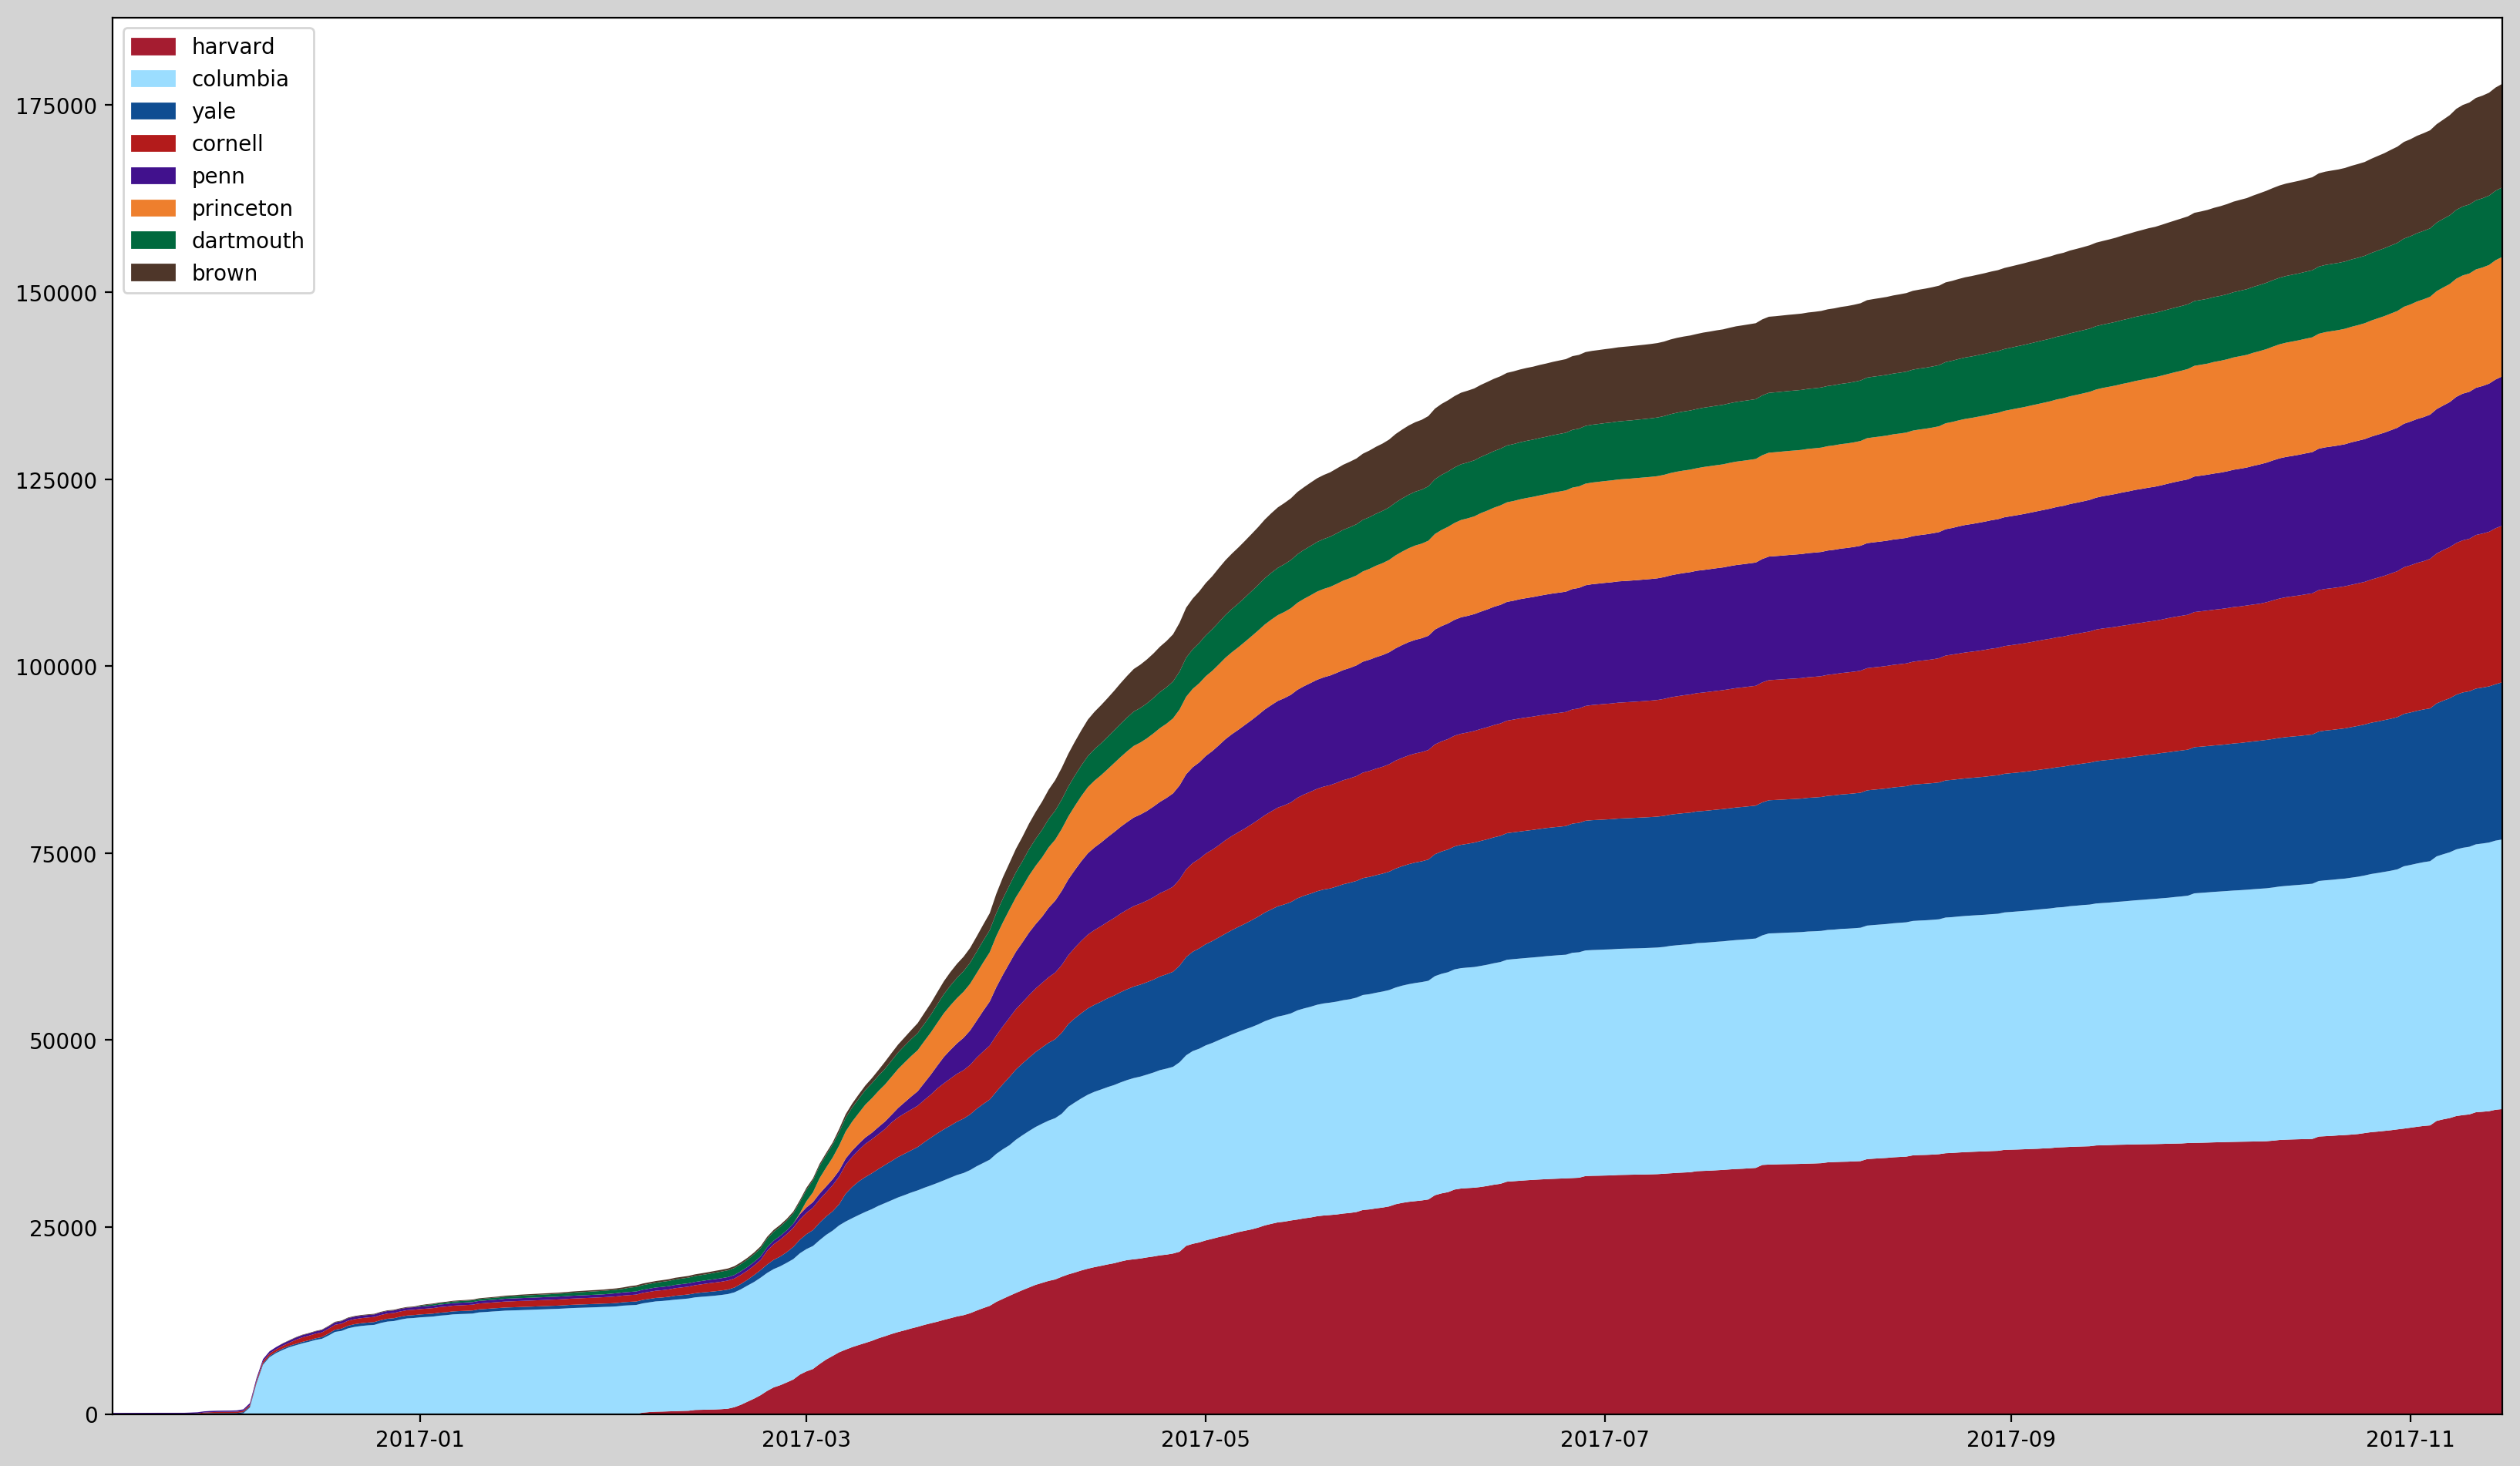

In [25]:
stackplot_size(count_df)

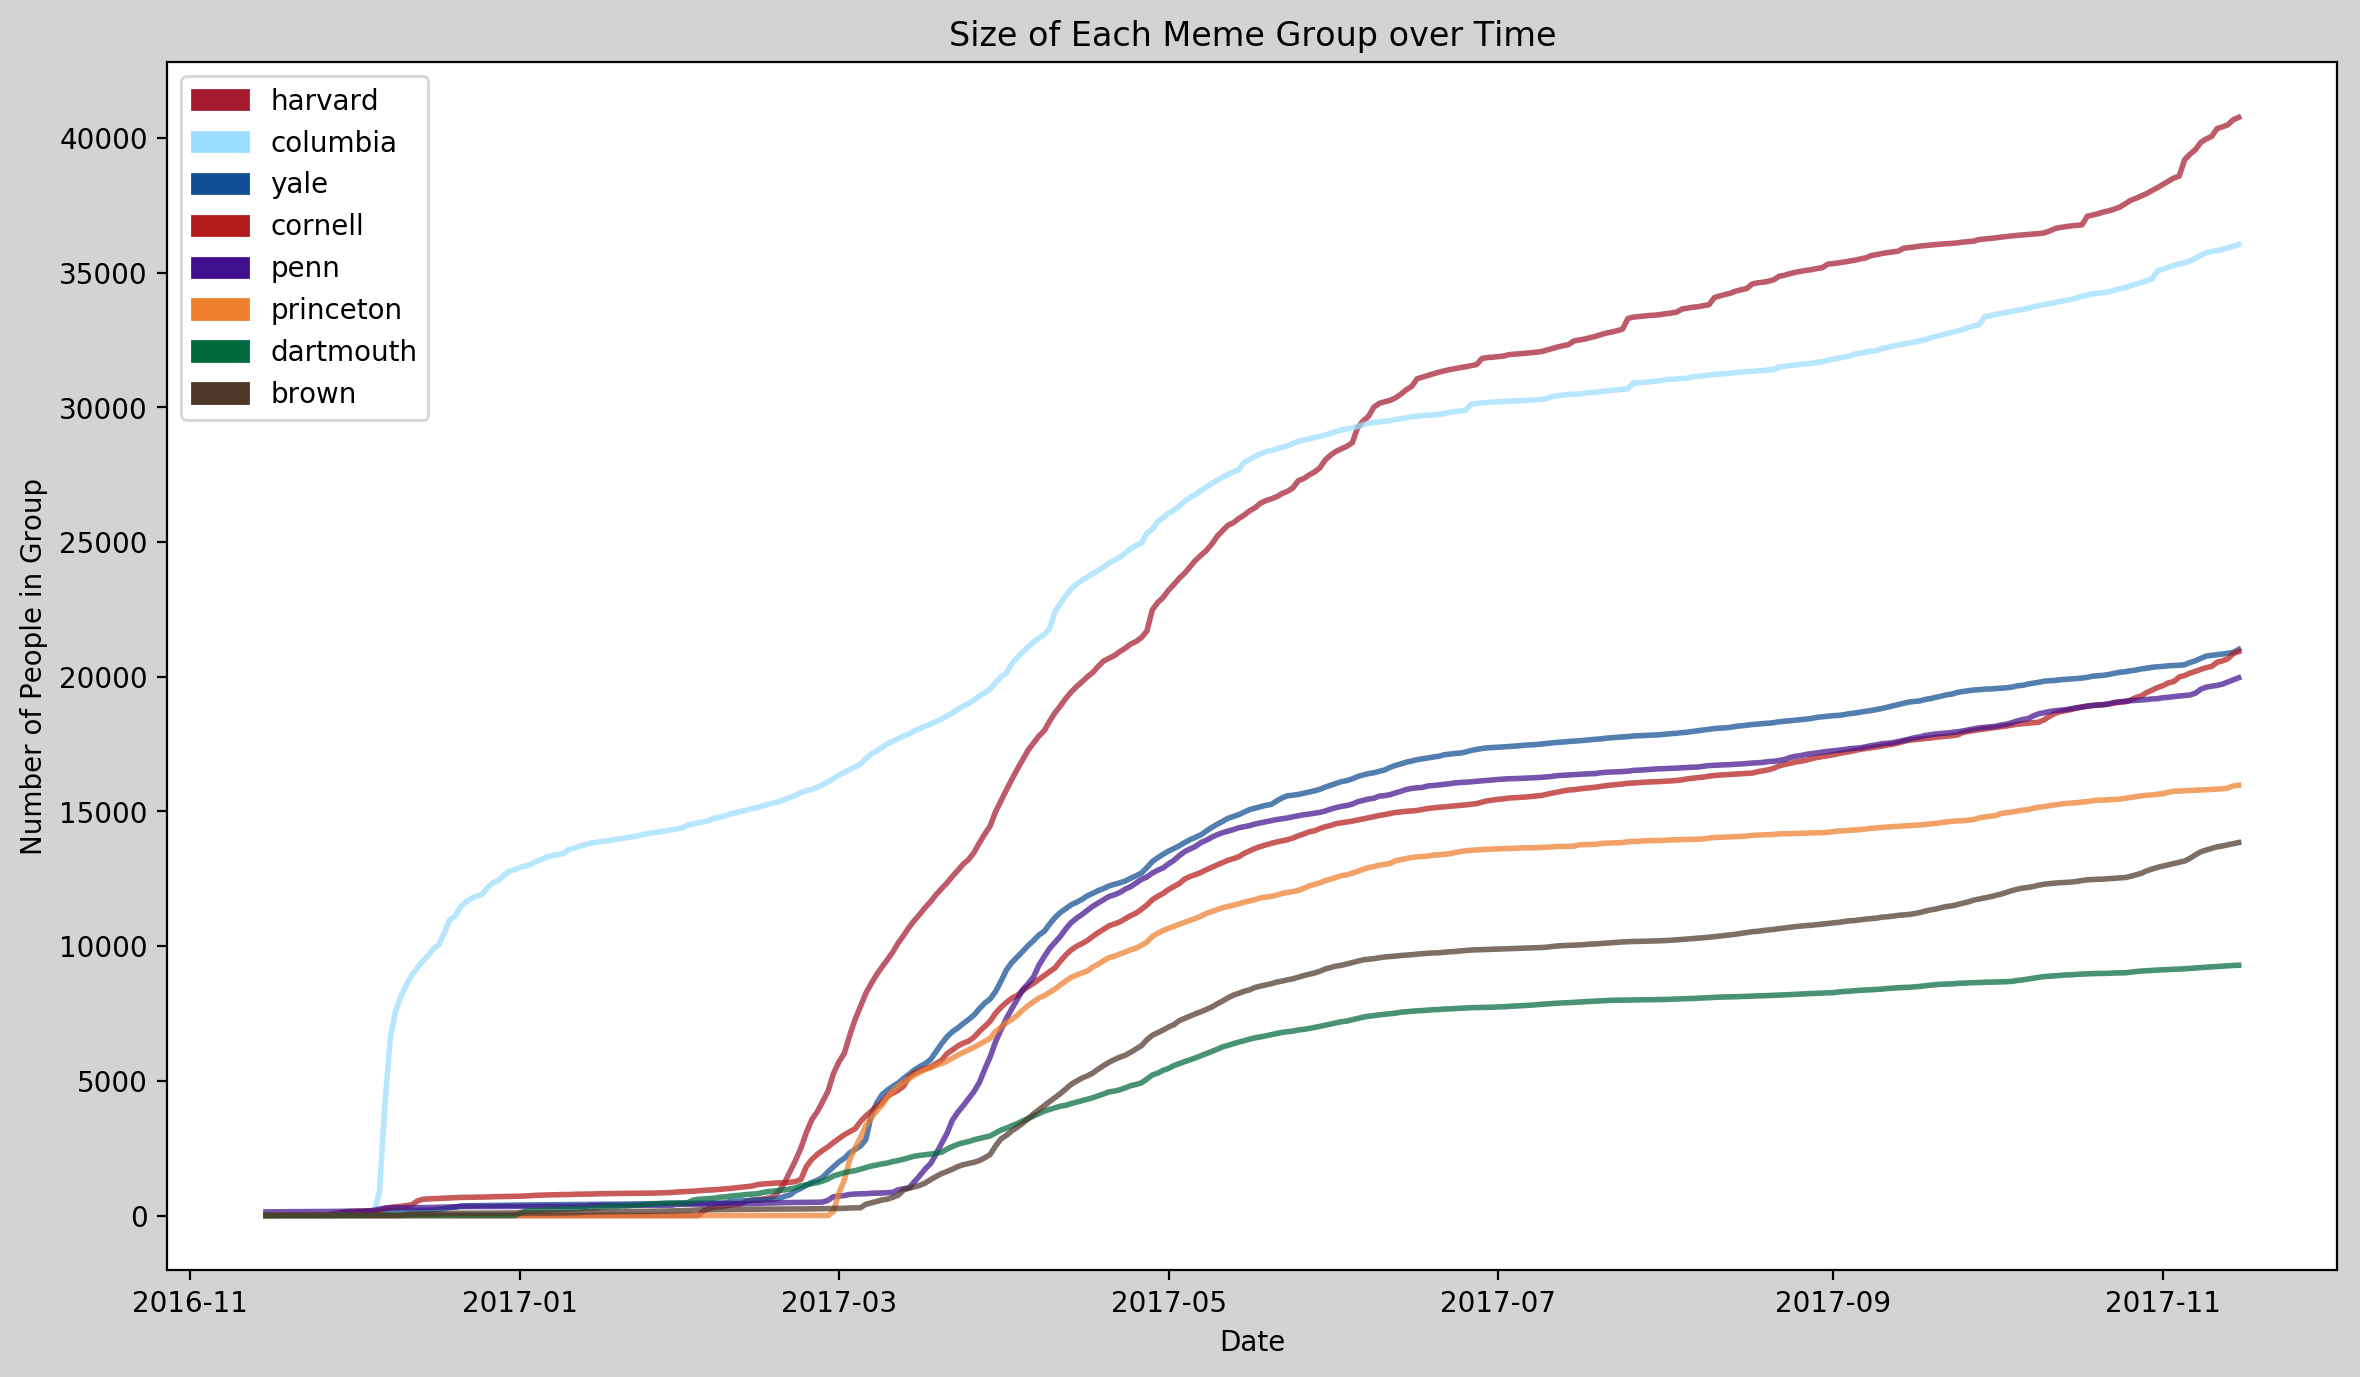

In [26]:
plot_group_size(count_df)

In [ ]:
plot_top_n_posters(post_df, n=10)

In [ ]:
plot_post_counts(post_df[post_df['group'] == '../columbia'])

In [ ]:
# dfd['text'] = dfd['caption'] + dfd['title'] + df['img_text']
# dfd[dfd['text'].str.lower().str.contains('daddy', na=False)]

In [ ]:
# def find_duped(list_ids):
#     imgs = [(post_id, ihash.whash(Image.open(make_fn(post_id)), hash_size=8))
#             for post_id in list_ids]
#     pairs_to_test = list(combos(imgs, 2))
#     for pair_imgs in pairs_to_test:
#         id1, hash1 = pair_imgs[0]
#         id2, hash2 = pair_imgs[1]
#         print(hash1==hash2)
#     return pairs_to_test